In [29]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns



In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# Load your data
df = pd.read_excel('consolidated_output.xlsx')

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [34]:
# Filtering and keeping rows where 'classes' column does not contain 'others'
df = df[df['class'] != 'Others']

# Filtering out rows where 'text_data' column contains the specified string
df = df[~df['text_data'].str.contains("Error: Unable to decode JSON in column 'Response Text'")]

In [35]:
# Apply preprocessing
df['text_data'] = df['text_data'].replace('\n', ' ', regex=True)
df['text_data'] = df['text_data'].apply(preprocess_text)

In [36]:
# Convert class labels to numerical format
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

In [37]:
#Transform encoded labels
unique_classes = df['class_encoded'].unique()
decoded_labels = label_encoder.inverse_transform(unique_classes)
print(unique_classes)

# Display the fitted classes and the decoded labels
print("Fitted Classes:", label_encoder.classes_)
print("Decoded Labels:", decoded_labels)

[0 1 2 3 4 5 6 7 8]
Fitted Classes: ['Assets' 'Compliance' 'Employee' 'Investments' 'Loans' 'Outsourcing'
 'Transportation' 'Utilities and Supplies' 'Withdrawals']
Decoded Labels: ['Assets' 'Compliance' 'Employee' 'Investments' 'Loans' 'Outsourcing'
 'Transportation' 'Utilities and Supplies' 'Withdrawals']


In [38]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['text_data'], df['class_encoded'], test_size=0.3, random_state=42)


In [39]:
# Tokenization and vectorization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token

maxlen = 100  # Define maximum sequence length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)



In [40]:
# Create and train the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/200
14/14 [==============================] - 1s 21ms/step - loss: 2.2848 - accuracy: 0.2600 - val_loss: 2.2619 - val_accuracy: 0.3279
Epoch 2/200
14/14 [==============================] - 0s 9ms/step - loss: 2.2393 - accuracy: 0.3653 - val_loss: 2.2170 - val_accuracy: 0.3169
Epoch 3/200
14/14 [==============================] - 0s 8ms/step - loss: 2.1852 - accuracy: 0.3630 - val_loss: 2.1613 - val_accuracy: 0.3224
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 2.1203 - accuracy: 0.3677 - val_loss: 2.0968 - val_accuracy: 0.3169
Epoch 5/200
14/14 [==============================] - 0s 9ms/step - loss: 2.0444 - accuracy: 0.3607 - val_loss: 2.0280 - val_accuracy: 0.3169
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 1.9658 - accuracy: 0.3630 - val_loss: 1.9576 - val_accuracy: 0.3115
Epoch 7/200
14/14 [==============================] - 0s 9ms/step - loss: 1.8852 - accuracy: 0.3583 - val_loss: 1.8982 - val_accuracy: 0.3115
Epoch 8/200


In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

6/6 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.8361
Accuracy: 0.8360655903816223


In [42]:
# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

6/6 [==============================] - 0s 3ms/step


In [43]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.79      0.70      0.74        33
           2       0.85      0.94      0.89        47
           3       1.00      0.89      0.94         9
           4       1.00      0.50      0.67         4
           5       0.78      0.85      0.81        33
           6       1.00      0.40      0.57         5
           7       0.84      0.94      0.89        33
           8       0.80      0.50      0.62         8

    accuracy                           0.84       183
   macro avg       0.89      0.75      0.79       183
weighted avg       0.84      0.84      0.83       183



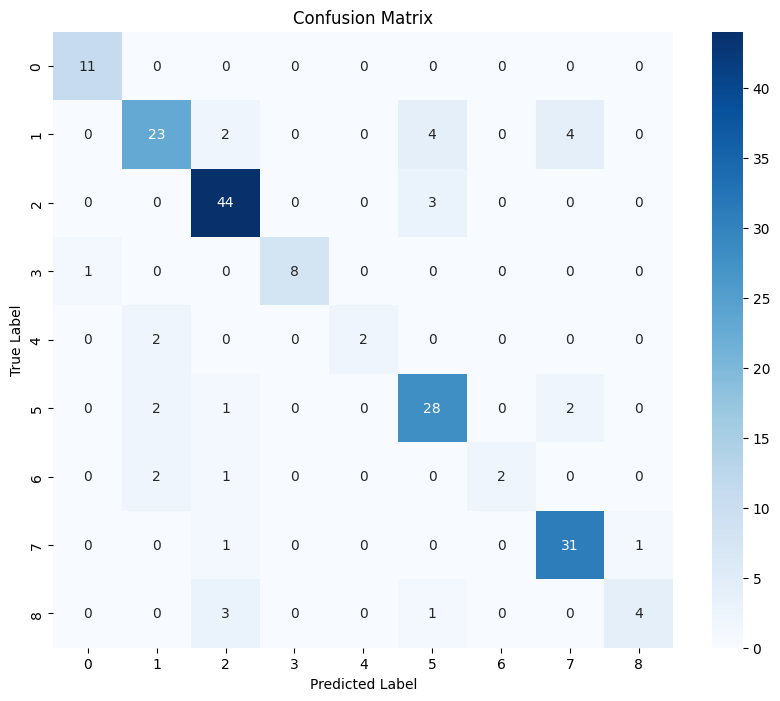

In [44]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
print(df['class'].value_counts())


Employee                  147
Outsourcing               134
Utilities and Supplies    131
Compliance                 93
Assets                     29
Investments                29
Withdrawals                23
Transportation             16
Loans                       8
Name: class, dtype: int64


In [46]:
# Save the trained model
model.save('my_model')

In [47]:
# Convert the TensorFlow model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('my_model')  # Load the saved model
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)